This analysis uses a dataset on credit risk analysis from a financial institution with the aim of predicting whether a loan will be paid or not.

The failure to pay back the loan is called a default (value 1 in our response variable).

In [1]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#Importing Libraries

import pandas as pd
import seaborn as sns
import numpy as np
import statistics as sts
import matplotlib.pyplot as plt
import random

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn. ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import BaggingClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import classification_report

In [3]:
#Reading the database

df = pd.read_csv("/content/credit_risk_dataset.csv", sep=",")
df

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26


In [4]:
#checking data info and type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [5]:
#checking for duplicated data
df.duplicated().sum()

165

In [6]:
#dropping duplicated data
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [7]:
#renaming some of the columns
df = df.rename(columns={'person_age': 'Age',
                        'person_income': 'Annual_Income',
                        'person_home_ownership': 'Home_Ownership',
                        'person_emp_length':'Employment_Lenght',
                        'loan_amnt':'loan_amount',
                        'loan_int_rate':'loan_interest_rate',
                        'cb_person_default_on_file':'Historical_default',
                        'cb_person_cred_hist_length':'Credit_History_lenght'})

In [8]:
#Checking value_counts for cat. variables
for col in df.columns:
    if df[col].dtype == 'object': 
        print(df[col].value_counts())

RENT        16378
MORTGAGE    13369
OWN          2563
OTHER         106
Name: Home_Ownership, dtype: int64
EDUCATION            6411
MEDICAL              6042
VENTURE              5682
PERSONAL             5498
DEBTCONSOLIDATION    5189
HOMEIMPROVEMENT      3594
Name: loan_intent, dtype: int64
A    10703
B    10387
C     6438
D     3620
E      963
F      241
G       64
Name: loan_grade, dtype: int64
N    26686
Y     5730
Name: Historical_default, dtype: int64


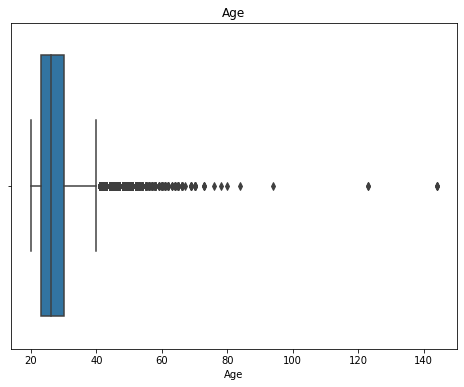

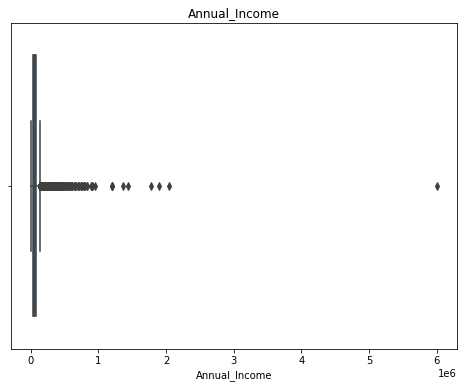

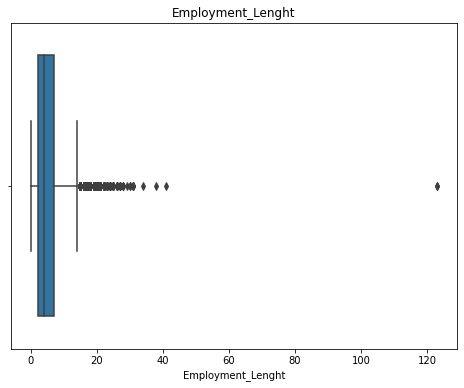

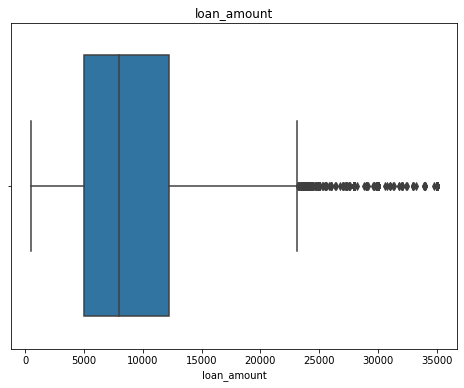

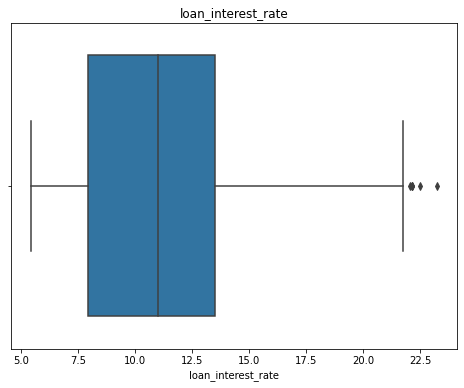

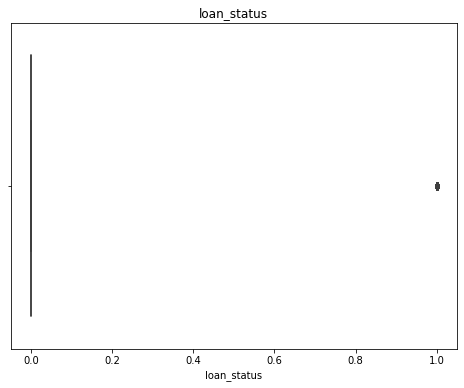

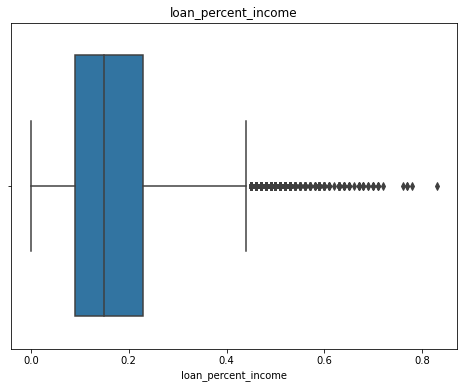

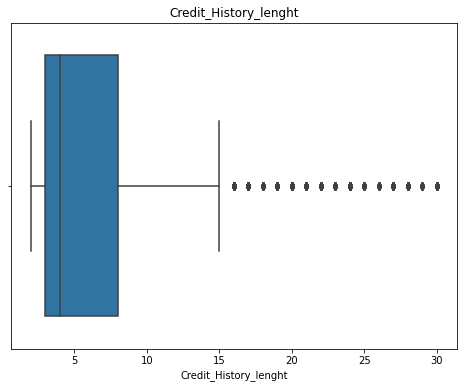

In [9]:
#checking boxplots for each num. variable
for col in df.columns:
    if df[col].dtype != 'object':
        fig, ax = plt.subplots(figsize=(8, 6))
        sns.boxplot(x=col, data=df, ax=ax)
        ax.set_title(col)
        plt.show()

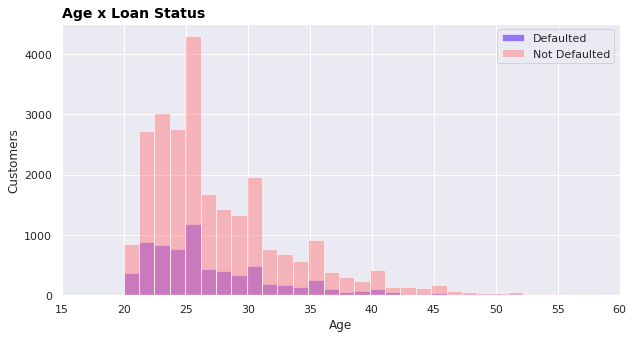

In [10]:
plt.figure(figsize=(10,5))
sns.set(style="darkgrid")
sns.histplot(x='Age', hue='loan_status', data=df, palette='gnuplot2_r', bins=100);
plt.title('Age x Loan Status', loc = 'left', fontsize=14, fontweight='bold', color='black')
plt.xlim(15, 60)
plt.xlabel("Age")
plt.ylabel("Customers")
plt.legend(title='', loc='upper right', labels=['Defaulted', 'Not Defaulted'])

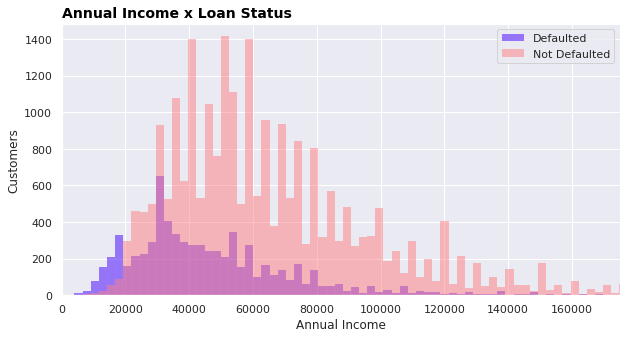

In [11]:
plt.figure(figsize=(10,5))
sns.set(style="darkgrid")
sns.histplot(x='Annual_Income', hue='loan_status', data=df, palette='gnuplot2_r');
plt.title('Annual Income x Loan Status', loc = 'left', fontsize=14, fontweight='bold', color='black')
plt.xlim(0,175000)
plt.xlabel("Annual Income")
plt.ylabel("Customers")
plt.legend(title='', loc='upper right', labels=['Defaulted', 'Not Defaulted'])

In [12]:
df.loc[df['Home_Ownership'] == 'OTHER','Home_Ownership'] = 'RENT'
df['Home_Ownership'].value_counts()

RENT        16484
MORTGAGE    13369
OWN          2563
Name: Home_Ownership, dtype: int64

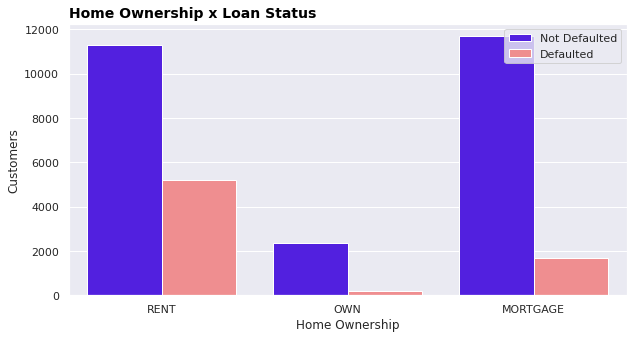

In [13]:
plt.figure(figsize=(10,5))
sns.set(style="darkgrid")
sns.countplot(x='Home_Ownership', hue='loan_status', data=df, palette='gnuplot2')
plt.title('Home Ownership x Loan Status', loc = 'left', fontsize=14, fontweight='bold', color='black')
plt.xlabel("Home Ownership")
plt.ylabel("Customers")
plt.legend(title='', loc='upper right', labels=['Not Defaulted', 'Defaulted'])

Text(0, 0.5, 'Annual Income')

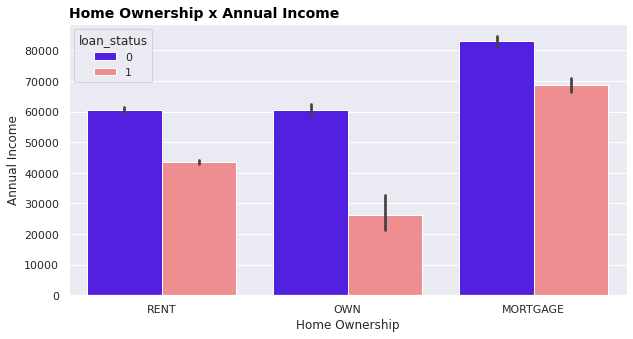

In [14]:
plt.figure(figsize=(10,5))
sns.set(style="darkgrid")
sns.barplot(x="Home_Ownership", y="Annual_Income",hue="loan_status", palette='gnuplot2',data=df)
plt.title('Home Ownership x Annual Income', loc = 'left', fontsize=14, fontweight='bold', color='black')
plt.xlabel("Home Ownership")
plt.ylabel("Annual Income")

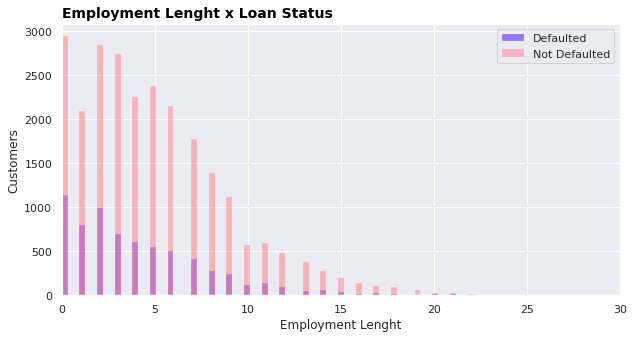

In [15]:
plt.figure(figsize=(10,5))
sns.set(style="darkgrid")
sns.histplot(x='Employment_Lenght', hue='loan_status', data=df, palette='gnuplot2_r');
plt.title('Employment Lenght x Loan Status', loc = 'left', fontsize=14, fontweight='bold', color='black')
plt.xlabel("Employment Lenght")
plt.ylabel("Customers")
plt.xlim(0,30)
plt.legend(title='', loc='upper right', labels=['Defaulted', 'Not Defaulted'])

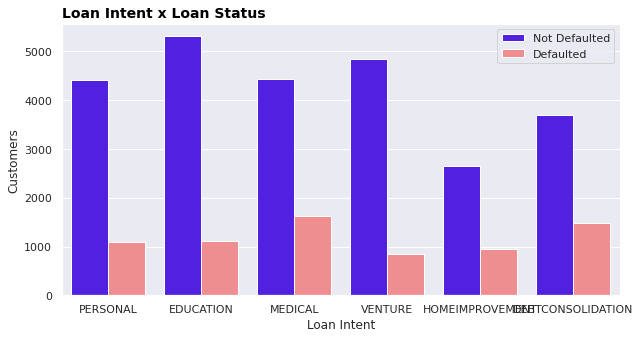

In [16]:
plt.figure(figsize=(10,5))
sns.set(style="darkgrid")
sns.countplot(x='loan_intent', hue='loan_status', data=df, palette='gnuplot2')
plt.title('Loan Intent x Loan Status', loc = 'left', fontsize=14, fontweight='bold', color='black')
plt.xlabel("Loan Intent")
plt.ylabel("Customers")
plt.legend(title='', loc='upper right', labels=['Not Defaulted', 'Defaulted'])

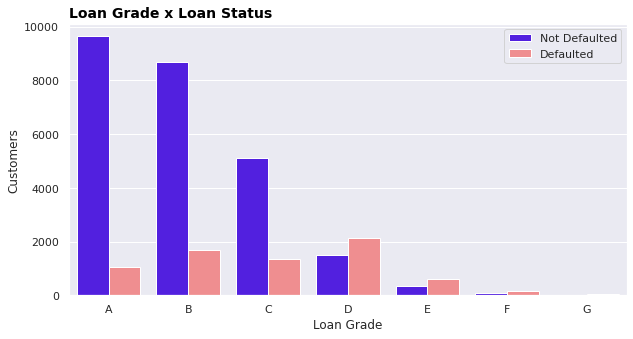

In [17]:
plt.figure(figsize=(10,5))
sns.set(style="darkgrid")
sns.countplot(x='loan_grade', hue='loan_status', data=df, palette='gnuplot2', order=['A','B','C','D','E','F','G'])
plt.title('Loan Grade x Loan Status', loc = 'left', fontsize=14, fontweight='bold', color='black')
plt.xlabel("Loan Grade")
plt.ylabel("Customers")
plt.legend(title='', loc='upper right', labels=['Not Defaulted', 'Defaulted'])

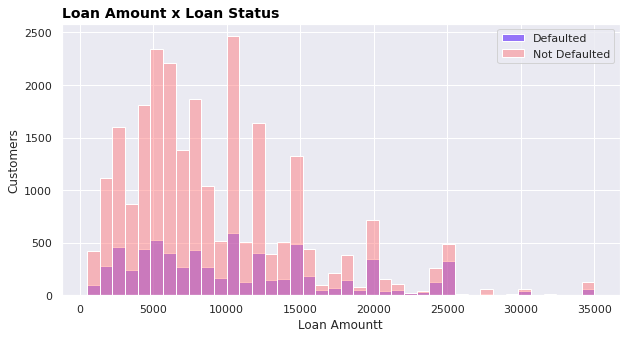

In [18]:
plt.figure(figsize=(10,5))
sns.set(style="darkgrid")
sns.histplot(x='loan_amount', hue='loan_status', data=df, palette='gnuplot2_r', bins=40);
plt.title('Loan Amount x Loan Status', loc = 'left', fontsize=14, fontweight='bold', color='black')
plt.xlabel("Loan Amountt")
plt.ylabel("Customers")
plt.legend(title='', loc='upper right', labels=['Defaulted', 'Not Defaulted'])

Text(0, 0.5, 'Loan Amount')

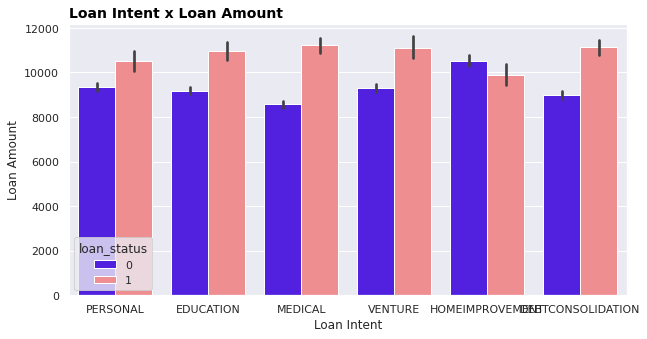

In [19]:
plt.figure(figsize=(10,5))
sns.set(style="darkgrid")
sns.barplot(x="loan_intent", y="loan_amount",hue="loan_status", palette='gnuplot2',data=df)
plt.title('Loan Intent x Loan Amount', loc = 'left', fontsize=14, fontweight='bold', color='black')
plt.xlabel("Loan Intent")
plt.ylabel("Loan Amount")

Text(0, 0.5, 'Loan Amount')

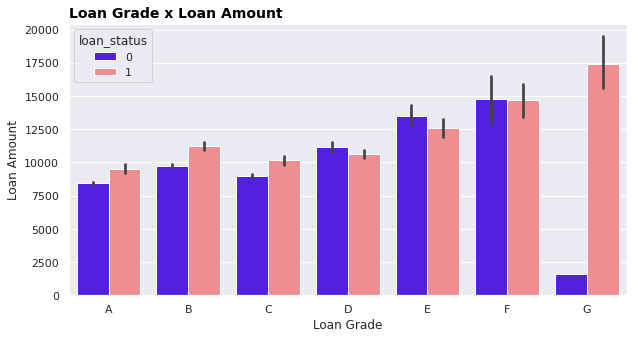

In [20]:
plt.figure(figsize=(10,5))
sns.set(style="darkgrid")
sns.barplot(x="loan_grade", y="loan_amount",hue="loan_status", palette='gnuplot2',data=df, order=['A','B','C','D','E','F','G'])
plt.title('Loan Grade x Loan Amount', loc = 'left', fontsize=14, fontweight='bold', color='black')
plt.xlabel("Loan Grade")
plt.ylabel("Loan Amount")

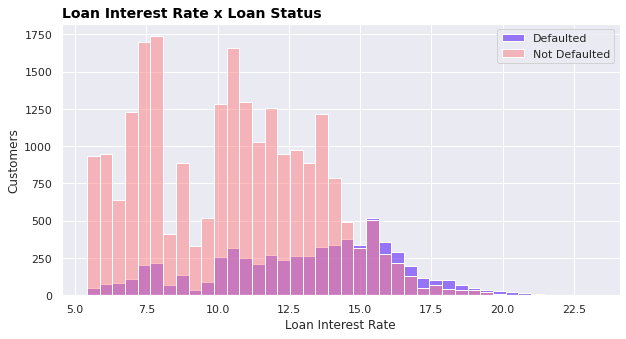

In [21]:
plt.figure(figsize=(10,5))
sns.set(style="darkgrid")
sns.histplot(x='loan_interest_rate', hue='loan_status', data=df, palette='gnuplot2_r', bins=40);
plt.title('Loan Interest Rate x Loan Status', loc = 'left', fontsize=14, fontweight='bold', color='black')
plt.xlabel("Loan Interest Rate")
plt.ylabel("Customers")
plt.legend(title='', loc='upper right', labels=['Defaulted', 'Not Defaulted'])

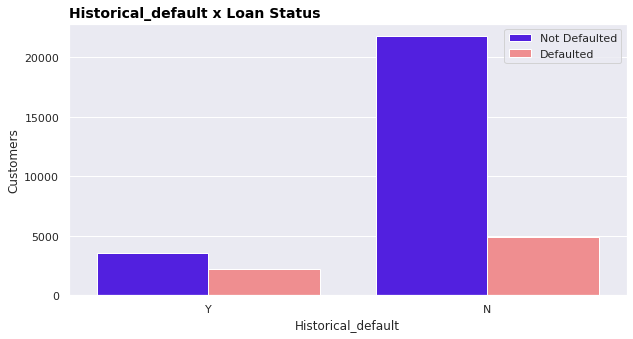

In [22]:
plt.figure(figsize=(10,5))
sns.set(style="darkgrid")
sns.countplot(x='Historical_default', hue='loan_status', data=df, palette='gnuplot2')
plt.title('Historical_default x Loan Status', loc = 'left', fontsize=14, fontweight='bold', color='black')
plt.xlabel("Historical_default")
plt.ylabel("Customers")
plt.legend(title='', loc='upper right', labels=['Not Defaulted', 'Defaulted'])

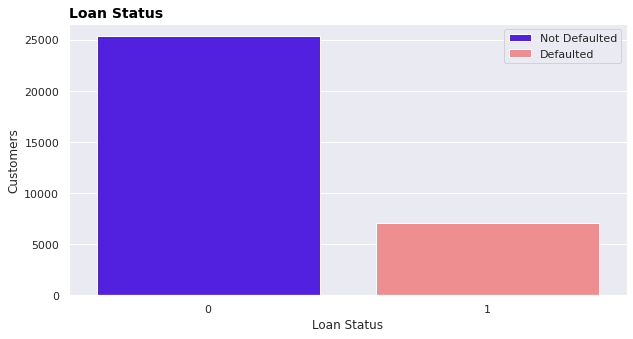

In [23]:
plt.figure(figsize=(10,5))
sns.set(style="darkgrid")
sns.countplot(x='loan_status', hue='loan_status',dodge=False,  data=df, palette='gnuplot2')
plt.title('Loan Status', loc = 'left', fontsize=14, fontweight='bold', color='black')
plt.xlabel("Loan Status")
plt.ylabel("Customers")
plt.legend(title='', loc='upper right', labels=['Not Defaulted', 'Defaulted'])

A few insights about the dataset:



*   The age range of 20-30 is where most people request loans from this institution, and it is also the range with the most defaulters.

*   People with low annual income tend to default on their loans.

*   People living in rented homes are the ones who request loans the most and also the ones who default the most.
*   The majority of loans in this institution are intended for educational or medical purposes, with the latter having the most defaulters.


*   The majority of loans are classified as A, B, or C with fewer defaulters than non-defaulters. However, as the classifications increase to D and beyond, the number of defaulters begins to dominate over non-defaulters. In general, D-grade has the highest number of defaulters.


*   The predominant interest rate range is between 5% and 15%. The higher the interest rate of the loans, the higher the number of defaulters. The range between 10-17% contains the majority of defaulters.



*   Historically, a significant portion of those who have defaulted on loans have not paid back again. However, most new defaulters have paid off old debts (or have not previously requested a loan - the dataset does not seem to make this distinction).





The following steps of the analysis are:
 


*   Using a cross validation method to split the data
*   Data pre-processing
*   Study several classification models to find the best one for each metric








In [24]:
df = df.reset_index(drop=True)

X = df.drop(['loan_status'], axis=1)
y = df['loan_status']


In [25]:
#Defining cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [26]:
#pipeline for numerical variables
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])


In [27]:
# pipeline for categorical variables
cat_pipeline = Pipeline([
    ('encoder', FunctionTransformer(pd.get_dummies, validate=False))
])

In [28]:
#preprocessor for cat. e num. variables
preprocessor = ColumnTransformer([
    ('num', num_pipeline, X.select_dtypes(include=np.number).columns.tolist()),
    ('cat', cat_pipeline, X.select_dtypes(include='object').columns.tolist())
])

Cross-validation  LogisticRegression
Classification Report  LogisticRegression:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      5066
           1       0.76      0.56      0.64      1417

    accuracy                           0.87      6483
   macro avg       0.82      0.75      0.78      6483
weighted avg       0.86      0.87      0.86      6483

Cross-validation  GaussianNB
Classification Report  GaussianNB:
              precision    recall  f1-score   support

           0       0.86      0.94      0.90      5066
           1       0.67      0.46      0.54      1417

    accuracy                           0.83      6483
   macro avg       0.77      0.70      0.72      6483
weighted avg       0.82      0.83      0.82      6483

Cross-validation  DecisionTreeClassifier
Classification Report  DecisionTreeClassifier:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      5066
     

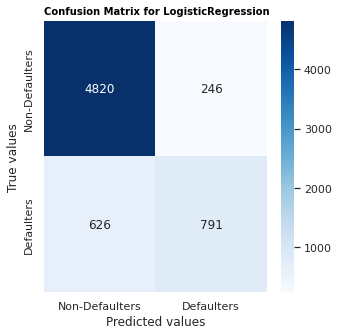

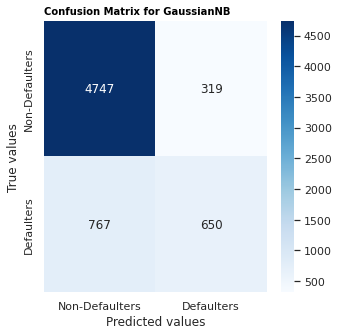

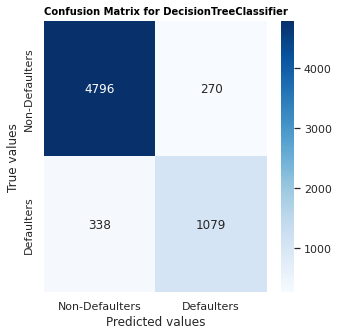

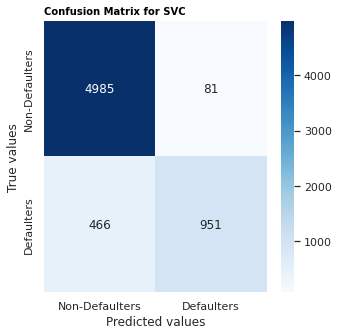

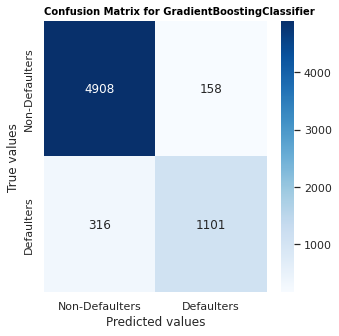

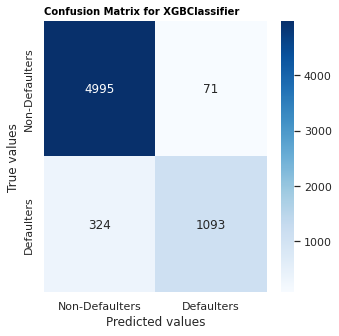

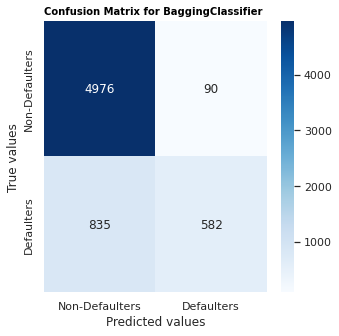

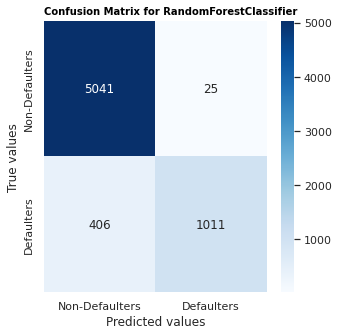

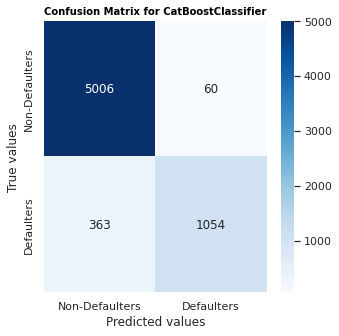

In [29]:
#creating pipeline with preprocessor and standardscaler
pipe = make_pipeline( preprocessor, StandardScaler())

#List of models
models = [LogisticRegression(),
          GaussianNB(),
          DecisionTreeClassifier(max_depth=50, min_samples_leaf=2),
          SVC(kernel='rbf', C=1, gamma='scale'),
          GradientBoostingClassifier(learning_rate=0.7, max_depth=5, n_estimators=250,random_state = 42),
          XGBClassifier(learning_rate=0.4, max_depth=5,
                        n_estimators = 200, max_features = 8,
                        random_state = 42),
          BaggingClassifier(max_features=13, max_samples=100, n_estimators=50, base_estimator = DecisionTreeClassifier(),
                            random_state = 42),
          RandomForestClassifier(bootstrap=False, max_depth=10, max_features=7,
                       min_samples_leaf=9, n_estimators=50,random_state = 42),
          CatBoostClassifier(learning_rate=0.4, max_depth=5,
                                     n_estimators = 200, random_state = 42)
          ]
                                    
#Creating dataframes to store the metrics and the predictions
metrics_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Recall', 'Precision', 'F1 Score'])
results_df = pd.DataFrame(columns=['Model', 'Train/Test', 'Actual', 'Predicted'])

#Loop over the models
for model in models:
    
    #lists for the metrics
    accuracy_scores = []
    recall_scores = []
    precision_scores = []
    f1_scores = []

    #loop over the folds
    for train_index, test_index in skf.split(X,y):
          #Splitting data into train and test sets
          X_train, X_test = X.iloc[train_index], X.iloc[test_index]
          y_train, y_test = y.iloc[train_index], y.iloc[test_index]          

          #Fit imputer on training data imputing missing values in both train and test sets
          X_train = pd.DataFrame(X_train, columns=X.columns)
          X_test = pd.DataFrame(X_test, columns=X.columns)

          top = X_train['Annual_Income'].quantile(0.975)
          X_train.loc[X_train['Annual_Income'] > top, 'Annual_Income'] = top

          top = X_test['Annual_Income'].quantile(0.975)
          X_test.loc[X_test['Annual_Income'] > top, 'Annual_Income'] = top

          top = X_train['Age'].quantile(0.999)
          X_train.loc[X_train['Age'] > top, 'Age'] = top

          top = X_test['Age'].quantile(0.999)
          X_test.loc[X_test['Age'] > top, 'Age'] = top

          top = X_train['Employment_Lenght'].quantile(0.975)
          X_train.loc[X_train['Employment_Lenght'] > top, 'Employment_Lenght'] = top

          top = X_test['Employment_Lenght'].quantile(0.975)
          X_test.loc[X_test['Employment_Lenght'] > top, 'Employment_Lenght'] = top

          #Fiting the model
          X_train = pipe.fit_transform(pd.DataFrame(X_train, columns=X.columns))
          X_test = pipe.transform(pd.DataFrame(X_test, columns=X.columns))

          model.fit(X_train, y_train)

          #Predictions and metrics of the model
          y_pred = model.predict(X_test)
          y_train_pred = model.predict(X_train)
          accuracy_scores.append(accuracy_score(y_test, y_pred))
          recall_scores.append(recall_score(y_test, y_pred))
          precision_scores.append(precision_score(y_test, y_pred))
          f1_scores.append(f1_score(y_test, y_pred))

    #checking the running model      
    print(f"Cross-validation  {model.__class__.__name__}")
    print(f"Classification Report  {model.__class__.__name__}:")
    print(classification_report(y_test, y_pred))


    #Mean of the metrics
    mean_accuracy = np.mean(accuracy_scores)
    mean_recall = np.mean(recall_scores)
    mean_precision = np.mean(precision_scores)
    mean_f1s = np.mean(f1_scores)

    #Using metrics_df to store the metrics
    metrics_df = metrics_df.append({'Model': model.__class__.__name__,
                                    'Accuracy': mean_accuracy,
                                    'Recall': mean_recall,
                                    'Precision': mean_precision,
                                    'F1 Score': mean_f1s},
                                    ignore_index=True)
      
    #Confusion Matrix for each model
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, cmap='Blues',fmt="d", annot=True,
                  xticklabels=['Non-Defaulters', 'Defaulters'], yticklabels=['Non-Defaulters', 'Defaulters'])
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title(f'Confusion Matrix for {model.__class__.__name__}',
                loc='Left', fontsize=10, fontweight='bold', color='black')
      
    #Storing predictions for train and test samples in results_df
    results_df = results_df.append(pd.DataFrame({'Model': [model.__class__.__name__]*len(y_train_pred), 
                                                      'Train/Test': ['train']*len(y_train_pred),
                                                      'Actual': y_train, 
                                                      'Predicted': y_train_pred}), ignore_index=True)
    results_df = results_df.append(pd.DataFrame({'Model': [model.__class__.__name__]*len(y_pred), 
                                                      'Train/Test': ['test']*len(y_pred),
                                                      'Actual': y_test, 
                                                      'Predicted': y_pred}), ignore_index=True)
      


In [30]:
metrics_df

,Model,Accuracy,Recall,Precision,F1 Score
0,LogisticRegression,0.865529,0.555227,0.765468,0.643607
1,GaussianNB,0.829127,0.405283,0.688528,0.495796
2,DecisionTreeClassifier,0.901191,0.754127,0.785675,0.769504
3,SVC,0.912574,0.650588,0.928345,0.764869
4,GradientBoostingClassifier,0.924667,0.773734,0.867671,0.817982
5,XGBClassifier,0.935865,0.757514,0.937176,0.837746
6,BaggingClassifier,0.863524,0.434755,0.881393,0.581277
7,RandomForestClassifier,0.931053,0.699819,0.979023,0.816078
8,CatBoostClassifier,0.934230,0.738892,0.949200,0.830852


In this project we are looking for the models with best recall, precision and F1-Score.

After evaluating the metrics we have:



*   GradientBoostingClassifier has the best recall.

*   RandomForestClassifier has the best precision.

*   XGBoost has the best F1-Score.





